In [33]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score


In [34]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


df = pd.read_csv(r"C:\Users\jiaro\DS4021-final-project\Data\train_set.csv")

X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)


In [35]:
class NNClassifier(nn.Module):
    def __init__(self, input_dim, hidden=64, dropout=0.2, activation="relu", num_classes=7):
        super().__init__()

        act = nn.ReLU() if activation == "relu" else nn.Tanh()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            act,
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [36]:
def train_model(X_train, y_train, X_val, y_val, params):
    hidden = params["hidden"]
    lr = params["lr"]
    epochs = params["epochs"]
    batch_size = params["batch_size"]
    activation = params["activation"]
    dropout = params["dropout"]

    model = NNClassifier(
        input_dim=X_train.shape[1],
        hidden=hidden,
        dropout=dropout,
        activation=activation,
        num_classes=len(np.unique(y_train))
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
    val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_val).float()).argmax(dim=1).numpy()

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="weighted")

    return model, acc, f1


In [37]:
param_grid = {
    "hidden": [32, 64, 128],
    "dropout": [0.0, 0.2, 0.5],
    "activation": ["relu", "tanh"],
    "lr": [1e-3, 1e-4],
    "batch_size": [32, 64],
    "epochs": [20]
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

results = []
best_f1 = -1
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    print("\nTesting params:", params)
    accs = []
    f1s = []

    for train_idx, val_idx in skf.split(X_train, y_train_enc):

        # split
        X_tr_df = X_train.iloc[train_idx]
        y_tr = y_train_enc[train_idx]
        X_val_df = X_train.iloc[val_idx]
        y_val = y_train_enc[val_idx]

        # preprocess inside CV
        X_tr_np = preprocessor.fit_transform(X_tr_df)
        X_val_np = preprocessor.transform(X_val_df)

        # train
        model, acc, f1 = train_model(X_tr_np, y_tr, X_val_np, y_val, params)

        accs.append(acc)
        f1s.append(f1)

    mean_acc = np.mean(accs)
    mean_f1 = np.mean(f1s)

    print(f" → Mean Acc={mean_acc:.3f}, Mean F1={mean_f1:.3f}")

    results.append({"params": params, "acc": mean_acc, "f1": mean_f1})

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_model = model
        best_params = params



Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 32, 'lr': 0.001}
 → Mean Acc=0.799, Mean F1=0.794

Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 32, 'lr': 0.0001}
 → Mean Acc=0.461, Mean F1=0.417

Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 64, 'lr': 0.001}
 → Mean Acc=0.827, Mean F1=0.824

Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 64, 'lr': 0.0001}
 → Mean Acc=0.511, Mean F1=0.459

Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 128, 'lr': 0.001}
 → Mean Acc=0.882, Mean F1=0.882

Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 128, 'lr': 0.0001}
 → Mean Acc=0.585, Mean F1=0.547

Testing params: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'hidden': 32, 'lr':

In [ ]:
# use best params
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

# retrain!
best_model, _, _ = train_model(
    X_train_final, y_train_enc,
    X_test_final, y_test_enc,
    best_params
)

# final pred
best_model.eval()
with torch.no_grad():
    preds_test = best_model(torch.tensor(X_test_final).float()).argmax(dim=1).numpy()

test_acc = accuracy_score(y_test_enc, preds_test)
test_f1 = f1_score(y_test_enc, preds_test, average="weighted")

print("\nBEST PARAMS:", best_params)
print("TEST ACC:", test_acc)
print("TEST F1:", test_f1)



BEST PARAMS: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 128, 'lr': 0.001}
TEST ACC: 0.9201183431952663
TEST F1: 0.920729074552619



TEST ACCURACY: 0.9201183431952663
TEST F1: 0.920729074552619

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.93      0.93        43
      Normal_Weight       0.80      0.82      0.81        45
     Obesity_Type_I       0.96      0.93      0.94        55
    Obesity_Type_II       0.98      0.98      0.98        48
   Obesity_Type_III       1.00      0.98      0.99        52
 Overweight_Level_I       0.93      0.87      0.90        47
Overweight_Level_II       0.83      0.92      0.87        48

           accuracy                           0.92       338
          macro avg       0.92      0.92      0.92       338
       weighted avg       0.92      0.92      0.92       338



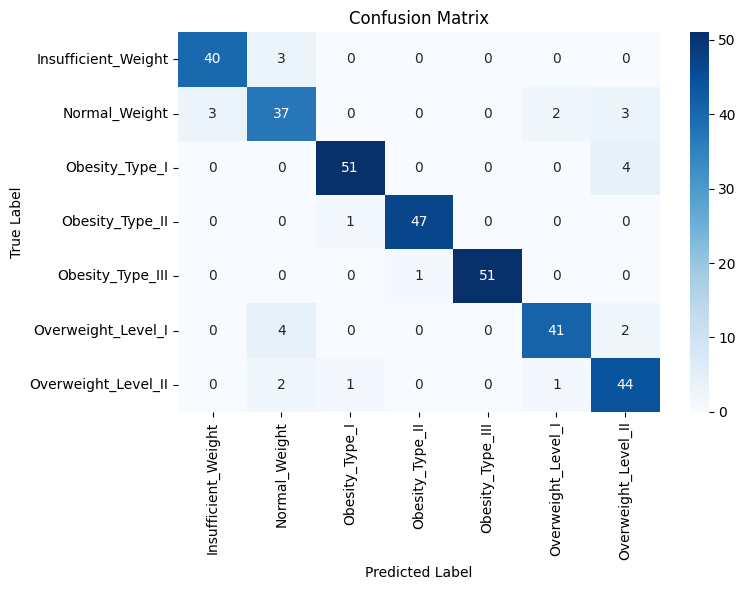

In [40]:
best_model.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_final).float()
    outputs = best_model(X_test_tensor)
    preds = outputs.argmax(1).cpu().numpy()

print("\nTEST ACCURACY:", accuracy_score(y_test_enc, preds))
print("TEST F1:", f1_score(y_test_enc, preds, average="weighted"))

print("\nClassification Report:")
print(classification_report(
    y_test_enc,
    preds,
    target_names=label_encoder.classes_
))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
